# Implementing NFT Price Class Prediction System with SageMaker Built-In Algorithm
_**Making Price Class Suggestion for NFT Using Factorization Machines**_

--- 

*This work is based on content from [Implementing Recommender System notebook](https://github.com/aws-samples/sagemaker-ml-workflow-with-apache-airflow/blob/master/notebooks/amazon-video-recommender_using_fm_algo.ipynb)*

---

# Table of Contents

* [Chapter 1](#chapter1): Setup

* [Chapter 2](#chapter2): Data
    * [2.1](#2_1): Explore
    * [2.2](#2_2): Clean
    * [2.3](#2_3): Preprocess
 

 
* [Chapter 3](#chapter3): Model training

* [Chapter 4](#chapter4): Inference

* [Chapter 5](#chapter5): Evaluate Model Performance

* [Chapter 6](#chapter5): Model Tuning

* [Chapter 7](#chapter7): Clean-up


---

## Chapter 1: <a class="anchor" id="chapter1"></a> Setup


Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [3]:
import boto3
import sagemaker

from sagemaker.tuner import HyperparameterTuner, ContinuousParameter
from sagemaker.analytics import HyperparameterTuningJobAnalytics, TrainingJobAnalytics

bucket = 'sagemaker-us-west-2-369454669781'
prefix = 'sagemaker/fm-recsys'
role = 'arn:aws:iam::369454669781:role/service-role/AmazonSageMaker-ExecutionRole-20220415T151752'

sess = sagemaker.Session()
smclient = boto3.Session().client('sagemaker')

Now let's load the Python libraries we'll need for the remainder of this example notebook.

In [4]:
#Essentials
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import numpy as np; np.random.seed(2022)
import random

#Image creation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go

#Image display
from IPython.display import Image as image
from IPython.display import display

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

#Metrics of accuracy
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import mean
from numpy import std

#Other
import psycopg2 as pg
from nbformat import current
import itertools as it
import io
import os
import sys
import time
from scipy.sparse import lil_matrix
import boto3
import json
import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.9/site-packages/nbformat/current.py:15: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  warnings.warn("""nbformat.current is deprecated.


In [5]:
# plot aesthetics
sns.set(color_codes=True)
sns.set_context('paper')
five_thirty_eight = ["#30a2da", "#fc4f30", "#e5ae38", "#6d904f", "#8b8b8b",]
sns.set_palette(five_thirty_eight)

%matplotlib inline

## Chapter 2: <a class="anchor" id="chapter2"></a> Data

### 2.1  <a class="anchor" id="2_1"></a> Explore

Let's read the data into a Pandas DataFrame so that we can begin to understand it.

In [6]:
engine = pg.connect("dbname='opensea' user='marfapopova21' host='opensea.c5pkb2dzarva.us-west-2.rds.amazonaws.com' port='5432' password='qwerty123'")
df1 = pd.read_sql('select * from nfts.collections', con=engine)
df1 = df1.dropna(how='all', axis=1)
df1 = df1.dropna(how='all')
df1.head()
len(df1)

/usr/local/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,collection_name,created_date,collection_status,nft_version,tokens,owner_number,featured,hidden,nsfw
0,Dispatch-Messaging,2022-04-06T21:49:20.343522,not_requested,None,None,7356207.0,False,False,False
1,test,2022-04-12T17:54:03.412074,not_requested,3.0,1,3050053.0,False,False,False
2,3ASTER EGGZ,2022-04-12T17:49:14.605766,not_requested,None,0,7471608.0,False,False,False
3,Testv2chib2,2022-04-12T17:51:35.428359,not_requested,None,0,5909669.0,False,False,False
4,Test Model 4,2022-04-12T17:50:33.114878,not_requested,3.0,None,7396100.0,False,False,False


7500

In [7]:
engine = pg.connect("dbname='opensea' user='marfapopova21' host='opensea.c5pkb2dzarva.us-west-2.rds.amazonaws.com' port='5432' password='qwerty123'")
df2 = pd.read_sql('select * from nfts.finances', con=engine)
df2 = df2.dropna(how='all', axis=1)
df2 = df2.dropna(how='all')
df2.head()
len(df2)

/usr/local/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,collection_name,asset_contract_type,require_email,day_avg_price,week_avg_price,month_avg_price,total_volume,total_sales,total_supply,max_price,min_price,average_price,only_proxied_transfers,is_subject_to_whitelist,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points
0,Dispatch-Messaging,semi-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250
1,test,non-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250
2,3ASTER EGGZ,non-fungible,False,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,False,False,0,250
3,Testv2chib2,non-fungible,False,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,False,False,0,250
4,Test Model 4,non-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250


7500

In [8]:
# Merge the 2 dataframes on collection name
df = pd.merge(df1, df2, on = 'collection_name')
df.head()
len(df)

,collection_name,created_date,collection_status,nft_version,tokens,owner_number,featured,hidden,nsfw,asset_contract_type,require_email,day_avg_price,week_avg_price,month_avg_price,total_volume,total_sales,total_supply,max_price,min_price,average_price,only_proxied_transfers,is_subject_to_whitelist,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points
0,Dispatch-Messaging,2022-04-06T21:49:20.343522,not_requested,None,None,7356207.0,False,False,False,semi-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250
1,Dispatch-Messaging,2022-04-06T21:49:20.343522,not_requested,None,None,7356207.0,False,False,False,semi-fungible,False,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,False,False,0,250
2,Dispatch-Messaging,2022-04-11T12:25:09.603872,not_requested,None,None,7461686.0,False,False,False,semi-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250
3,Dispatch-Messaging,2022-04-11T12:25:09.603872,not_requested,None,None,7461686.0,False,False,False,semi-fungible,False,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,False,False,0,250
4,test,2022-04-12T17:54:03.412074,not_requested,3.0,1,3050053.0,False,False,False,non-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250


596130

In [9]:
df.columns

Index(['collection_name', 'created_date', 'collection_status', 'nft_version',
       'tokens', 'owner_number', 'featured', 'hidden', 'nsfw',
       'asset_contract_type', 'require_email', 'day_avg_price',
       'week_avg_price', 'month_avg_price', 'total_volume', 'total_sales',
       'total_supply', 'max_price', 'min_price', 'average_price',
       'only_proxied_transfers', 'is_subject_to_whitelist',
       'opensea_buyer_fee_basis_points', 'opensea_seller_fee_basis_points'],
      dtype='object')

We can see this dataset includes information like:

- `collection_name`: NFT collection name.
- `created_date`: NFT collection release date.
- `collection_status`: The collection's approval status within OpenSea.
- `nft_version`: 
- `tokens`: Total supply of NFTs in the collection (?).
- `owner_number`: Unique owner ID number.
- `featured`: A boolean datatype, showing whether the NFT has a featured artist (True) or is created solo (False).
- `hidden`: 
- `nsfw`: A boolean datatype, showing whether the NFT has explicit content (True) or not (False).
- `asset_contract_type`: 
- `require_email`: 
- `day_avg_price`: Average NFT price over 24 hours.
- `week_avg_price`: Average NFT price over 24 hours.
- `month_avg_price`: Average NFT price over 24 hours.
- `total_volume`: 
- `total_sales`: 
- `total_supply`: 
- `max_price`: 
- `min_price`: 
- `average_price`: 
- `only_proxied_transfers`: 
- `is_subject_to_whitelist`:
- `opensea_buyer_fee_basis_points`: 
- `opensea_seller_fee_basis_points`: 

For this example, let's limit ourselves to all but `owner_number`, `max_price`, and `min_price`. Including additional features in our system from other tables of the schema could be beneficial, but would require substantial processing (particularly the text data) which would take us beyond the scope of this notebook.

*Note: we'll keep `collection_name` on the dataset to help verify our recommendations later in the notebook, but it will not be used in algorithm training.*

In [10]:
df = df.drop(['owner_number', 'max_price', 'min_price'], axis=1)
len(df)

596130

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596130 entries, 0 to 596129
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   collection_name                  455505 non-null  object 
 1   created_date                     455505 non-null  object 
 2   collection_status                596130 non-null  object 
 3   nft_version                      84029 non-null   object 
 4   tokens                           80345 non-null   object 
 5   featured                         596130 non-null  bool   
 6   hidden                           596130 non-null  bool   
 7   nsfw                             596130 non-null  bool   
 8   asset_contract_type              455505 non-null  object 
 9   require_email                    596130 non-null  bool   
 10  day_avg_price                    596130 non-null  float64
 11  week_avg_price                   596130 non-null  float64
 12  mo

In [12]:
# Show number of all existing data types in the dataframe
print(df.dtypes.astype(str).value_counts())

object     8
float64    7
bool       6
dtype: int64


In [13]:
df['collection_name'].nunique()

3314

In [14]:
df['collection_name'].value_counts(ascending=False)

Unidentified contract    326041
CryptoPunks               26244
Pawn Tickets              23409
SquareNFT                 14641
Pawn Loans                 9025
                          ...  
test collection               1
Test NFT CORE                 1
Lord Ganesha                  1
OneCDNFT                      1
TheImaginaryOnesNft           1
Name: collection_name, Length: 3314, dtype: int64

In [15]:
df['collection_name'].value_counts().loc[lambda x : x<326041] 

CryptoPunks            26244
Pawn Tickets           23409
SquareNFT              14641
Pawn Loans              9025
UTPN                    7396
                       ...  
test collection            1
Test NFT CORE              1
Lord Ganesha               1
OneCDNFT                   1
TheImaginaryOnesNft        1
Name: collection_name, Length: 3313, dtype: int64

In [16]:
# Difference between the number of all collection records in the dataset and unnamed ones
596130 - 326041

270089

Collections named "Unidentified contract" mean that their creators did not add public variable string. Hence, there are only 3313 unique collection names in the dataset, that contain 270089 labelled records.

Because most people haven't seen most videos, and people rate fewer videos than we actually watch, we'd expect our data to be sparse.  Our algorithm should work well with this sparse problem in general, but we may still want to clean out some of the long tail.  Let's look at some basic percentiles to confirm.

In [17]:
all_collections = df['collection_name'].value_counts()
named_collections = df['collection_name'].value_counts().loc[lambda x : x<326041] 
sales = df['total_sales'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
all_collections_q = pd.DataFrame(zip(quantiles, all_collections.quantile(quantiles)), columns=["quantile", "all collections"])
named_collections_q = pd.DataFrame(zip(quantiles, named_collections.quantile(quantiles)), columns=["quantile", "named collections"])
sales_q = pd.DataFrame(zip(quantiles, sales.quantile(quantiles)), columns=["quantile", "sales"])

all_collections_q.tail(10)
named_collections_q.tail(10)
sales_q.tail(10)

,quantile,all collections
7,0.25,1.0
8,0.50,1.0
9,0.75,1.0
10,0.90,9.0
11,0.95,25.0
12,0.96,25.0
13,0.97,36.0
14,0.98,81.0
15,0.99,225.0
16,1.00,326041.0


,quantile,named collections
7,0.25,1.00
8,0.50,1.00
9,0.75,1.00
10,0.90,9.00
11,0.95,25.00
12,0.96,25.00
13,0.97,36.00
14,0.98,76.92
15,0.99,225.00
16,1.00,26244.00


,quantile,sales
7,0.25,376.0
8,0.50,571.0
9,0.75,2191.5
10,0.90,6520.0
11,0.95,294709.5
12,0.96,352347.4
13,0.97,409985.3
14,0.98,467623.2
15,0.99,525261.1
16,1.00,582899.0


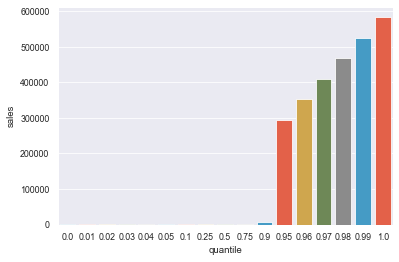

In [18]:
axs = sns.barplot(x="quantile", y="sales", data=sales_q, palette=five_thirty_eight)

### 2.2  <a class="anchor" id="2_2"></a> Clean

In [19]:
df = df.drop_duplicates()
print("Number of records after removing duplicates = {:10d}".format(df.shape[0]))

Number of records after removing duplicates =      41681


In [20]:
df.select_dtypes(include='object')

,collection_name,created_date,collection_status,nft_version,tokens,asset_contract_type,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points
0,Dispatch-Messaging,2022-04-06T21:49:20.343522,not_requested,None,None,semi-fungible,0,250
1,Dispatch-Messaging,2022-04-06T21:49:20.343522,not_requested,None,None,semi-fungible,0,250
2,Dispatch-Messaging,2022-04-11T12:25:09.603872,not_requested,None,None,semi-fungible,0,250
3,Dispatch-Messaging,2022-04-11T12:25:09.603872,not_requested,None,None,semi-fungible,0,250
4,test,2022-04-12T17:54:03.412074,not_requested,3.0,1,non-fungible,0,250
...,...,...,...,...,...,...,...,...
596125,AmazingToyMachine,2022-04-10T22:20:19.642343,not_requested,3.0,0,non-fungible,0,250
596126,SR49,2022-04-10T22:27:58.964315,not_requested,3.0,0,non-fungible,0,250
596127,Plunge2PO,2022-04-10T22:26:58.976898,not_requested,3.0,None,non-fungible,0,250
596128,Cheese,2022-04-10T22:26:03.694412,not_requested,3.0,2,non-fungible,0,250


Let's quantify the object column one by one where possible to quantify.

- `collection_name`: will not be converted.
- `created_date`: will be converted to a timestamp.
- `collection_status`:  "Can be *not_requested* (brand new collections), *requested* (collections that requested safelisting on our site), *approved* (collections that are approved on our site and can be found in search results), and *verified* (verified collections)." (OpenSea Developer Documentation, n.d.) Hence, we'll convert those to numbers ranging 0 to 3.
- `asset_contract_type`: will be converted by the same principle as `collection_status`.
- `nft_version` and `tokens`: None values will be converted to np.nan.
- `opensea_buyer_fee_basis_points` and `opensea_seller_fee_basis_points`: will be converted to numerics with a "try" method.

In [21]:
df['created_date'] = pd.to_datetime(df['created_date'])

In [22]:
df['created_date']

0        2022-04-06 21:49:20.343522
1        2022-04-06 21:49:20.343522
2        2022-04-11 12:25:09.603872
3        2022-04-11 12:25:09.603872
4        2022-04-12 17:54:03.412074
                    ...            
596125   2022-04-10 22:20:19.642343
596126   2022-04-10 22:27:58.964315
596127   2022-04-10 22:26:58.976898
596128   2022-04-10 22:26:03.694412
596129   2022-04-10 22:25:38.740942
Name: created_date, Length: 41681, dtype: datetime64[ns]

In [23]:
df['year'] = pd.DatetimeIndex(df['created_date']).year
df['month'] = pd.DatetimeIndex(df['created_date']).month

In [24]:
df['year'].value_counts()

2022.0    41573
Name: year, dtype: int64

In [25]:
df['month'].value_counts()

4.0    41320
3.0      250
1.0        2
2.0        1
Name: month, dtype: int64

Since there is only 1 year in the dataset and months are so unevenly disribubted, we will drop timestamp-related columns all together.

In [26]:
df.drop(columns = ['year', 'month', 'created_date'], inplace = True)

In [27]:
df['collection_status'].replace(['not_requested', 'requested', 'approved','verified'], [0,1,2,3], inplace=True)
df['collection_status'].value_counts()

0    41681
Name: collection_status, dtype: int64

In [28]:
df['asset_contract_type'].value_counts()

non-fungible     22107
semi-fungible    19466
Name: asset_contract_type, dtype: int64

In [29]:
df['asset_contract_type'].replace(['non-fungible', 'semi-fungible'], [0,1], inplace=True)
df['asset_contract_type'].value_counts()

0.0    22107
1.0    19466
Name: asset_contract_type, dtype: int64

In [30]:
df = df[df['nft_version'].notna()]
df = df[df['tokens'].notna()]

try:
  df['nft_version'] = df['nft_version'].astype(float)
  df['tokens'] = df['tokens'].astype(int)
except:
  print("Something went wrong")

In [31]:
try:
  df['opensea_buyer_fee_basis_points'] = df['opensea_buyer_fee_basis_points'].astype(float)
  df['opensea_seller_fee_basis_points'] = df['opensea_seller_fee_basis_points'].astype(float)
except:
  print("Something went wrong")

In [32]:
df.select_dtypes(include='object')
print(df.dtypes.astype(str).value_counts())

,collection_name
4,test
8,test
10,test
11,test
12,test
...,...
596119,RESPEK
596123,Boba
596125,AmazingToyMachine
596126,SR49


float64    11
bool        6
int64       2
object      1
dtype: int64


In [33]:
# Descriptive statistics of the transposed table
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
collection_status,7044.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
nft_version,7044.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
tokens,7044.0,88.111584,1422.531819,0.0,0.0,0.0,1.0,66049.0
asset_contract_type,7044.0,0.149631,0.356735,0.0,0.0,0.0,0.0,1.0
day_avg_price,7044.0,0.001932,0.023346,0.0,0.0,0.0,0.0,1.0
week_avg_price,7044.0,0.016440,0.359766,0.0,0.0,0.0,0.0,10.0
month_avg_price,7044.0,0.016440,0.359766,0.0,0.0,0.0,0.0,10.0
total_volume,7044.0,0.019455,0.368701,0.0,0.0,0.0,0.0,10.0
total_sales,7044.0,0.145798,0.857873,0.0,0.0,0.0,0.0,10.0
total_supply,7044.0,80.552953,582.430158,0.0,2.0,5.0,13.0,10000.0


In [34]:
# I exclude object type columns and those that range in (0,3)
numeric_df = df.drop(['collection_name', 'asset_contract_type', 'collection_status'], axis=1)
print(numeric_df.columns.astype(str))

Index(['nft_version', 'tokens', 'featured', 'hidden', 'nsfw', 'require_email',
       'day_avg_price', 'week_avg_price', 'month_avg_price', 'total_volume',
       'total_sales', 'total_supply', 'average_price',
       'only_proxied_transfers', 'is_subject_to_whitelist',
       'opensea_buyer_fee_basis_points', 'opensea_seller_fee_basis_points'],
      dtype='object')


<AxesSubplot:>

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, 'tokens'),
  Text(2, 0, 'day_avg_price'),
  Text(3, 0, 'week_avg_price'),
  Text(4, 0, 'month_avg_price'),
  Text(5, 0, 'total_volume'),
  Text(6, 0, 'total_sales'),
  Text(7, 0, 'total_supply'),
  Text(8, 0, 'average_price'),
  Text(9, 0, 'opensea_seller_fee_basis_points')])

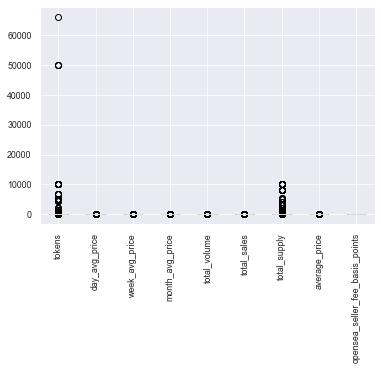

In [35]:
numeric_col = ['tokens', 'day_avg_price', 'week_avg_price', 'month_avg_price',
       'total_volume', 'total_sales', 'total_supply', 'average_price', 'opensea_seller_fee_basis_points']

df.boxplot(numeric_col)
plt.xticks(rotation=90)

### 2.3  <a class="anchor" id="2_3"></a> Preprocess

We will be using SageMaker's implementation of Factorization Machines (FM) for building a recommender system. The algorithm expects float32 tensors in protobuf whereas the data sets are pandas dataframe on disk. Most of the conversion effort is handled by the Amazon SageMaker Python SDK.

The FM algorithm will utilize sparse input and since the data sets are dense matrix, it has to be converted a sparse matrix with one-hot encoded feature vectors with customers and products. Thus, each sample in the data set will be a wide boolean vector with 178729 feature space (140344 customer + 38385 products) with only two values set to 1 with respect to the customer and product.

Following are the next steps

1. Feature engineering: create a dependent variable for demand, based on total sales column.
3. Split the cleaned data set into train and test data sets, and stratification.
4. Convert both the sets to protobuf encoded files.
5. Copy these files to an Amazon S3 bucket.
6. Configure and run a Factorization Machines training job on Amazon SageMaker.
7. Deploy the corresponding model to an endpoint.
8. Run predictions on test data set and validate.

#### 2.3.1  <a class="anchor" id="2_3_1"></a> Feature engineering

Below, I created a new variable that simply tells how many NFTs each artist has. I thought of it as NFT price may be linked to frequency of creator’s final artistic output.

<AxesSubplot:xlabel='total_sales'>

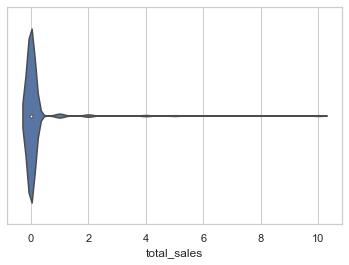

In [36]:
sns.set_theme(style="whitegrid")
sns.violinplot(data=df, x='total_sales')

In [37]:
df['total_sales'].value_counts()

0.0     6683
1.0      152
2.0       91
4.0       47
5.0       31
10.0      30
7.0        5
3.0        5
Name: total_sales, dtype: int64

In [38]:
demand_level = {}
for sales in df.total_sales:
  if sales <= 2:
    demand_level[sales] = 0 #low demand
  elif sales >= 7:
    demand_level[sales] = 2 #high demand
  else:
    demand_level[sales] = 1 #average demand

In [39]:
demand_level_df = pd.DataFrame(
    [{'total_sales': sales, "demand_level": demand_level} for (sales, demand_level) in demand_level.items()])
demand_level_df

,total_sales,demand_level
0,0.0,0
1,4.0,1
2,5.0,1
3,1.0,0
4,10.0,2
5,2.0,0
6,7.0,2
7,3.0,1


In [40]:
all_demands = pd.DataFrame(df['total_sales'])
average_demand_1 = (all_demands >= 2)
average_demand_2 = (all_demands <= 7)
average_full_prep = pd.concat([average_demand_1, average_demand_2], axis = 1) #axis=1 specifies horizontal stacking
average_demand = pd.DataFrame(average_full_prep.all(axis=1))
average_demand.rename(columns={0:'total_sales'},inplace=True)

low_demand = (all_demands <= 2)

high_demand = (all_demands >= 7)

In [41]:
all_demands = pd.concat([low_demand, average_demand, high_demand], axis = 1)*1 #axis=1 specifies horizontal stacking
all_demands

,total_sales,total_sales,total_sales
4,1,0,0
8,1,0,0
10,1,0,0
11,1,0,0
12,1,0,0
...,...,...,...
596119,1,0,0
596123,1,0,0
596125,1,0,0
596126,1,0,0


In [42]:
prep_classes = all_demands['total_sales'].sum().reset_index()
prep_classes.rename(columns={0:'NFT_collection_count'},inplace=True)
prep_classes.rename(columns={'index': 'category'}, inplace=True)
prep_classes

,category,NFT_collection_count
0,total_sales,6926
1,total_sales,179
2,total_sales,35


In [43]:
demand_classes = pd.DataFrame({'categories': ['low', 'average', 'high'],
                              'NFT_collection_count': [6926, 179, 35]})
demand_classes

,categories,NFT_collection_count
0,low,6926
1,average,179
2,high,35


<Figure size 1152x504 with 0 Axes>

Text(0.5, 1.0, 'Number of NFT collections in each demand class')

Text(0, 0.5, 'Number of NFT collections')

Text(0.5, 0, 'Demand category')

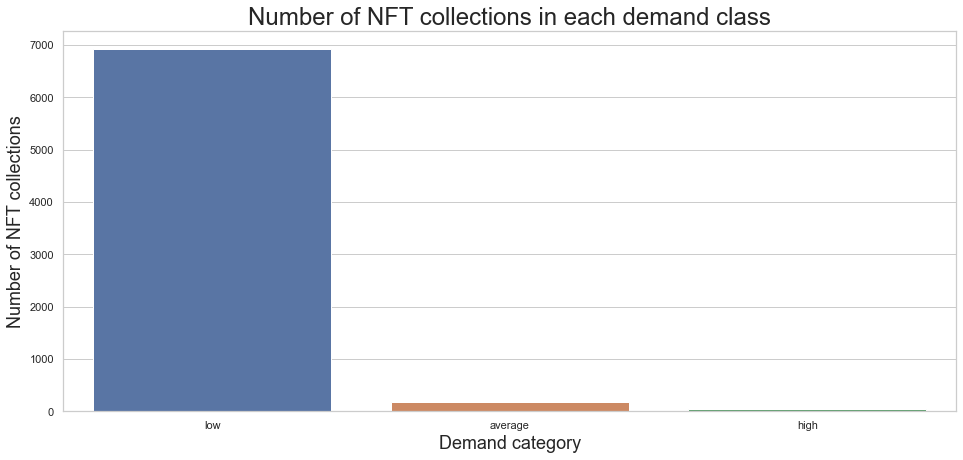

In [44]:
plt.figure(figsize=(16,7))
ax = sns.barplot(x = 'categories', y = 'NFT_collection_count', data = demand_classes)
plt.title('Number of NFT collections in each demand class', fontsize=24)
plt.ylabel('Number of NFT collections', fontsize=18)
plt.xlabel('Demand category', fontsize=18)

In [45]:
full_df = df.merge(demand_level_df,how='left', left_on='total_sales', right_on='total_sales')
full_df.head()
len(full_df)

,collection_name,collection_status,nft_version,tokens,featured,hidden,nsfw,asset_contract_type,require_email,day_avg_price,week_avg_price,month_avg_price,total_volume,total_sales,total_supply,average_price,only_proxied_transfers,is_subject_to_whitelist,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points,demand_level
0,test,0,3.0,1,False,False,False,0.0,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,False,0.0,250.0,0
1,test,0,3.0,1,False,False,False,0.0,False,0.0,0.0,0.0,0.0,0.0,3.0,0.0,False,False,0.0,250.0,0
2,test,0,3.0,1,False,False,False,0.0,False,0.0,0.0,0.0,0.0,0.0,4.0,0.0,False,False,0.0,250.0,0
3,test,0,3.0,1,False,False,False,0.0,False,0.0,0.0,0.0,0.0,0.0,2.0,0.0,False,False,0.0,250.0,0
4,test,0,3.0,1,False,False,False,0.0,False,0.0,0.0,0.0,0.0,0.0,10.0,0.0,False,False,0.0,250.0,0


7044

In [46]:
# Scale the explanatory variables
from sklearn.preprocessing import RobustScaler
stratified_df = full_df.drop(columns = ['demand_level', 'collection_name'])
stratified_df = pd.DataFrame(RobustScaler().fit_transform(stratified_df), columns=stratified_df.columns)
stratified_df 

,collection_status,nft_version,tokens,featured,hidden,nsfw,asset_contract_type,require_email,day_avg_price,week_avg_price,month_avg_price,total_volume,total_sales,total_supply,average_price,only_proxied_transfers,is_subject_to_whitelist,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.363636,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.181818,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090909,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.272727,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454545,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.181818,0.0,0.0,0.0,0.0,0.0
7040,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.272727,0.0,0.0,0.0,0.0,0.0
7041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.181818,0.0,0.0,0.0,0.0,0.0
7042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090909,0.0,0.0,0.0,0.0,0.0


In [47]:
demands = full_df[['demand_level']].copy()

In [48]:
final_df = pd.concat([stratified_df, demands], axis = 1)*1 #axis=1 specifies horizontal 
final_df

,collection_status,nft_version,tokens,featured,hidden,nsfw,asset_contract_type,require_email,day_avg_price,week_avg_price,month_avg_price,total_volume,total_sales,total_supply,average_price,only_proxied_transfers,is_subject_to_whitelist,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points,demand_level
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.363636,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.181818,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090909,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.272727,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454545,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.181818,0.0,0.0,0.0,0.0,0.0,0
7040,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.272727,0.0,0.0,0.0,0.0,0.0,0
7041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.181818,0.0,0.0,0.0,0.0,0.0,0
7042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090909,0.0,0.0,0.0,0.0,0.0,0


####

#### 2.3.2  <a class="anchor" id="2_3_2"></a>  Data splitting and scaling

Let's start by [splitting](https://docs.scipy.org/doc/numpy/reference/generated/numpy.split.html) in training, validation and test sets.  This will allow us to estimate the model's accuracy on videos our customers rated, but wasn't included in our training. We will use validation data set specifically for tuning model hyper-parameters.

In [49]:
train_df, validate_df, test_df = np.split(final_df.sample(frac=1), [int(.6*len(final_df)), int(.8*len(final_df))])

In [50]:
print("Number of rows in the training data set   = {:10d}".format(train_df.shape[0]))
print("Number of rows in the validation data set = {:10d}".format(validate_df.shape[0]))
print("Number of rows in the test data set       = {:10d}".format(test_df.shape[0]))

Number of rows in the training data set   =       4226
Number of rows in the validation data set =       1409
Number of rows in the test data set       =       1409


In [51]:
# get feature dimension

all_df = pd.concat([train_df, validate_df, test_df])
# Choose a response variable
Y = all_df['demand_level']

# Drop a response variable and collection name from the feature data set
X = all_df.drop(columns = ['demand_level'])

nb_demand_levels = np.unique(Y.values).shape[0]
nb_independent_vars = np.unique(X.values).shape[0]
feature_dim = nb_demand_levels + nb_independent_vars
print("Number of demand levels          = {:10d}".format(nb_demand_levels))
print("Number of independent variables  = {:10d}".format(nb_independent_vars))
print("Number of features               = {:10d}".format(feature_dim))

Number of demand levels          =          3
Number of independent variables  =        220
Number of features               =        223


#### 2.3.3  <a class="anchor" id="2_3_3"></a>  Building Sparse One-Hot Encoded Matrix

Let's define a function that takes the data set and returns a sparse feature matrix and numpy array with ratings.

In [52]:
def convert_sparse_matrix(df, nb_rows, nb_demand_levels, nb_independent_vars):
    # dataframe to array
    df_val = df.values

    # determine feature size
    nb_cols = nb_demand_levels + nb_independent_vars
    print("# of rows = {}".format(str(nb_rows)))
    print("# of cols = {}".format(str(nb_cols)))

    # extract customers and ratings
    df_X = df_val[:, 0:2]
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((nb_rows, nb_cols)).astype('float32')
    df_X[:, 1] = nb_demand_levels + df_X[:, 1]
    coords = df_X[:, 0:2]
    X[np.arange(nb_rows), coords[:, 0]] = 1
    X[np.arange(nb_rows), coords[:, 1]] = 1

    # create label with ratings
    Y = df_val[:, 2].astype('float32')

    # validate size and shape
    print(X.shape)
    print(Y.shape)
    assert X.shape == (nb_rows, nb_cols)
    assert Y.shape == (nb_rows, )

    return X, Y

In [53]:
print("Convert training data set to one-hot encoded sparse matrix")
train_X, train_Y = convert_sparse_matrix(train_df, train_df.shape[0], nb_demand_levels, nb_independent_vars)
print("Convert validation data set to one-hot encoded sparse matrix")
validate_X, validate_Y = convert_sparse_matrix(validate_df, validate_df.shape[0], nb_demand_levels, nb_independent_vars)
print("Convert test data set to one-hot encoded sparse matrix")
test_X, test_Y = convert_sparse_matrix(test_df, test_df.shape[0], nb_demand_levels, nb_independent_vars)

Convert training data set to one-hot encoded sparse matrix
# of rows = 4226
# of cols = 223
(4226, 223)
(4226,)
Convert validation data set to one-hot encoded sparse matrix
# of rows = 1409
# of cols = 223
(1409, 223)
(1409,)
Convert test data set to one-hot encoded sparse matrix
# of rows = 1409
# of cols = 223
(1409, 223)
(1409,)


#### 2.3.4  <a class="anchor" id="2_3_4"></a> Convert to Protobuf format and Upload to S3

We will use Sagemaker's utility function [`write_spmatrix_to_sparse_tensor`](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/amazon/common.py) to convert scipy sparse matrix to protobuf format.

In [54]:
def save_as_protobuf(X, Y, bucket, key):
    """Converts features and predictions matrices to recordio protobuf and
       writes to S3

    Args:
        X:
          2D numpy matrix with features
        Y:
          1D numpy matrix with predictions
        bucket:
          s3 bucket where recordio protobuf file will be staged
        prefix:
          s3 url prefix to stage prepared data to use for training the model
        key:
          protobuf file name to be staged

    Returns:
        s3 url with key to the protobuf data
    """
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}'.format(key)
    boto3.resource('s3', region_name='us-west-2').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket, obj)

In [55]:
s3_train_path = save_as_protobuf(train_X, train_Y, bucket, 'prepare/train/train.protobuf')
print("Training data set in protobuf format uploaded at {}".format(s3_train_path))
s3_val_path = save_as_protobuf(validate_X, validate_Y, bucket, 'prepare/validate/validate.protobuf')
print("Validation data set in protobuf format uploaded at {}".format(s3_val_path))

Training data set in protobuf format uploaded at s3://sagemaker-us-west-2-369454669781/prepare/train/train.protobuf
Validation data set in protobuf format uploaded at s3://sagemaker-us-west-2-369454669781/prepare/validate/validate.protobuf


In [56]:
def chunk(x, batch_size):
    """split array into chunks of batch_size
    """
    chunk_range = range(0, x.shape[0], batch_size)
    chunks = [x[p: p + batch_size] for p in chunk_range]
    return chunks

In [57]:
test_x_chunks = chunk(test_X, 10000)
test_y_chunks = chunk(test_Y, 10000)
N = len(test_x_chunks)
for i in range(N):
    test_data = save_as_protobuf(
        test_x_chunks[i],
        test_y_chunks[i],
        bucket,
        "prepare/test/test_" + str(i) + ".protobuf")
    print(test_data)

s3://sagemaker-us-west-2-369454669781/prepare/test/test_0.protobuf


## Chapter 3: <a class="anchor" id="chapter3"></a> Model Training

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. We'll use the Amazon SageMaker Python SDK to kick off training and monitor status until it is completed. In this example that takes between 4-7 minutes for 3-10 epochs. 

First, let's get the Sagemaker Factorization Machine container

In [58]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'factorization-machines')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


Next kick off the base estimator, making sure to pass in the necessary hyperparameters. Notice:

- `feature_dim` is set to 178729, which is the number of customers + products in the training data set.
- `predictor_type` is set to 'regressor' since we are trying to predict the rating
- `mini_batch_size` is set to 200. This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.
- `num_factors` is set to 64. Factorization machines find a lower dimensional representation of the interactions for all features. Making this value smaller provides a more parsimonious model, closer to a linear model, but may sacrifice information about interactions. Making it larger provides a higher-dimensional representation of feature interactions, but adds computational complexity and can lead to overfitting. In a practical application, time should be invested to tune this parameter to the appropriate value.

In [59]:
%time

output_location = 's3://{}/train/'.format(bucket)
s3_train_path = 's3://{}/prepare/train/train.protobuf'.format(bucket)
s3_val_path = 's3://{}/prepare/validate/validate.protobuf'.format(bucket)

fm = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c5.4xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)

fm.set_hyperparameters(feature_dim=feature_dim,
                      predictor_type='regressor',
                      mini_batch_size=200,
                      num_factors=512,
                      bias_lr=0.02,
                      epochs=10)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [61]:
fm.fit({'train': s3_train_path,'test': s3_val_path}, wait=False)

Amazon SageMaker built-in algorithms automatically compute and emit a variety of model training, evaluation, and validation metrics that can be captured from Cloudwatch using Sagemaker SDK. Since we are using FM built-in algorithm with predictor type as `regressor`, we can capture RMSE (root-mean-square error) of the model that measures the differences between the predicted values and the actual values.

Let's capture the RMSE of the model

In [62]:
training_job_name = fm._current_job_name
metric_name = 'train:rmse:epoch'

In [70]:
# run this cell to check current status of training job
fm_training_job_result = smclient.describe_training_job(TrainingJobName=training_job_name)

status = fm_training_job_result['TrainingJobStatus']
if status != 'Completed':
    print('Reminder: the training job has not been completed.')
else:
    print('The training job is completed')

The training job is completed


In [71]:
# plug-in the training job name and metrics to be captured
metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
metrics_dataframe

,timestamp,metric_name,value
0,0.0,train:rmse:epoch,1727.118842


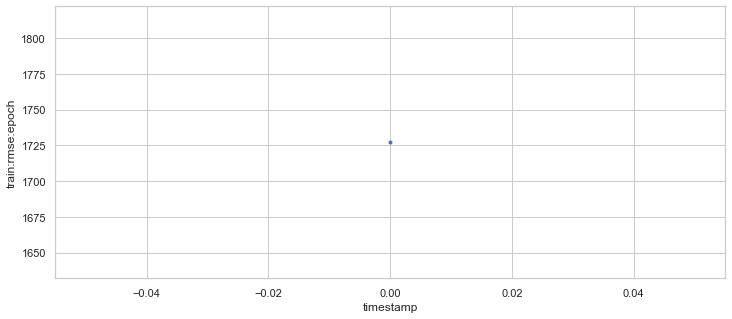

In [72]:
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

As the number of epochs increased, RMSE goes down which is a good sign that the predicted values are getting closer to the actual values from the test set. We can increase number of epochs or change the hyperparameters and try to tweak the model. Let's try to deploy this model and make predictions to see how close the predictions are. Then we can run a hyper-parameter tuning job to determine the best model.

#### Utility Functions

We will define some common utility functions here that will be used during inference and evaluating results

In [66]:
def convert_to_protobuf(X, Y=None):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    return buf

In [67]:
def convert_sparse_matrix_X(df, nb_rows, nb_customer, nb_products):
    # dataframe to array
    df_val = df.values

    # determine feature size
    nb_cols = nb_customer + nb_products
    
    # extract customers and ratings
    df_X = df_val[:,0:2]
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((nb_rows, nb_cols)).astype('float32')
    df_X[:,1] = nb_customer + df_X[:,1]
    coords = df_X[:,0:2]
    X[np.arange(nb_rows), coords[:, 0]] = 1
    X[np.arange(nb_rows), coords[:, 1]] = 1

    # validate size and shape
    assert X.shape == (nb_rows, nb_cols)
    
    return X

---

## Chapter 4: <a class="anchor" id="chapter4"></a> Inference

### 4.1  <a class="anchor" id="4_1"></a>  Real-Time Inference 

Since the model is trained, all it takes to deploy the model is a Sagemaker API call `deploy()` that creates the model package, sets up endpoint configuration and finally creates the endpoint.

In [79]:
fm_predictor = fm.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1)

------!

Predictions could be done by sending HTTP POST requests from a separate web service, but to keep things easy, we'll just use the `.predict()` method from the SageMaker Python SDK. The API expects JSON or RecordIO format for  request and JSON for response data.

In [80]:
fm_predictor.content_type = 'application/x-recordio-protobuf'

AttributeError: can't set attribute

Let's test the model with sample ratings from test data set using `predict()` API call

In [75]:
test_pb = convert_to_protobuf(test_X[1000:1010]).getvalue()

In [76]:
response = fm_predictor.predict(test_pb)
response

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from primary with message "content-type application/octet-stream not supported". See https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/factorization-machines-2022-04-18-11-28-10-402 in account 369454669781 for more information.

In [77]:
predicted = [round(r['score'], 2) for r in json.loads(response)['predictions']]
predicted

NameError: name 'response' is not defined

In [78]:
results_df = pd.DataFrame(zip(test_Y[1000:1010], predicted), columns = ["actual_rating", "predicted_rating"])
results_df

NameError: name 'predicted' is not defined

---

### 4.2  <a class="anchor" id="4_2"></a>  Batch Inference

Here we will perform batch inference on the test data set prepared earlier (chunking into multiple protobuf files). To run batch transform, create a model package for the transform endpoint 

- Create the model from the training estimator

In [81]:
fm_model = fm.create_model()

- Perform batch inference on the test data set and save results to S3

In [82]:
fm_transformer = fm_model.transformer(
    instance_type='ml.c4.xlarge', 
    instance_count=1, 
    strategy="MultiRecord", 
    output_path="s3://{}/transform/".format(bucket)
)

In [83]:
fm_transformer.transform(
    data="s3://{}/prepare/test/".format(bucket), 
    data_type='S3Prefix', 
    content_type="application/x-recordio-protobuf")

...........................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
Docker entrypoint called with argument(s): serve
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:120: DeprecationWarning: 

In [84]:
print('Waiting for transform job: ' + fm_transformer.latest_transform_job.job_name)
fm_transformer.wait()

Waiting for transform job: factorization-machines-2022-04-18-11-48-48-667
Docker entrypoint called with argument(s): serve
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
Docker entrypoint called with argument(s): serve
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/algorith

- Inference results will be stored in a separate file for each test file chunk. Let's download the results from S3 and merge them

In [85]:
def download_from_s3(bucket, key):
    s3 = boto3.resource('s3')
    obj = s3.Object( bucket, key)
    content = obj.get()['Body'].read()
    return content

In [86]:
test_preds = []
for i in range(N):
    key = 'transform/test_' + str(i) + '.protobuf.out'
    response = download_from_s3(bucket, key)
    result = [json.loads(row)["score"] for row in response.split("\n") if len(row) > 0]
    test_preds.extend(result)

TypeError: a bytes-like object is required, not 'str'

In [87]:
test_preds = np.array(test_preds)

In [88]:
test_preds.shape

(0,)

---

## Chapter 5: <a class="anchor" id="chapter5"></a> Evaluate Model Performance

Let's start by calculating a naive baseline to approximate how well our model is doing.  The simplest estimate would be to assume every user item rating is just the average rating over all ratings.

*Note, we could do better by using each individual video's average, however, in this case it doesn't really matter as the same conclusions would hold.*

In [ ]:
print('Naive MSE:', np.mean((test_df['star_rating'] - np.mean(train_df['star_rating'])) ** 2))

Now, we'll calculate predictions for our test dataset.

In [ ]:
print('MSE:', np.mean((test_Y - test_preds) ** 2))

We can see that our neural network and embedding model produces substantially better results (~1.44 vs 1.13 on the mean square error).

For recommender systems, subjective accuracy also matters.  Let's get some recommendations for a random user to see if they make intuitive sense.

In [ ]:
df_customer_6 = final_df[final_df['customer'] == 6].sort_values(['star_rating', 'product'], ascending=[False, True])
pd.concat((df_customer_6.head(10), df_customer_6.tail(10)))

As we can see, user #6 seems to like sprawling dramamtic television series and sci-fi, but they dislike silly comedies.

Now we'll loop through and predict user #6's ratings for every common video in the catalog, to see which ones we'd recommend and which ones we wouldn't.

In [ ]:
def create_payload(cust_id, nb_customer, nb_products, product_index):
    # prepare payload for user #6
    c = [cust_id] * nb_products
    p = product_index['product'].values
    x = pd.DataFrame(zip(c,p))
    p_x = convert_sparse_matrix_X(x, x.shape[0], nb_customer, nb_products)
    x_pb = convert_to_protobuf(p_x)
    return x_pb

In [ ]:
x_pb = create_payload(6, nb_demand_levels, nb_independent_vars, product_index)

In [ ]:
# make predictions using end-point created in Real-Time Inference
response = fm_predictor.predict(x_pb)
predictions = [round(r['score'], 2) for r in json.loads(response)['predictions']]

In [ ]:
predictions_df = pd.DataFrame({'product': product_index['product'],
                            'prediction': predictions})

In [ ]:
df_results_cust_6 = df_customer_6.merge(predictions_df, on=['product'])[['customer', 'customer_id', 'product', 'product_id', 'product_title', 'star_rating', 'prediction']]
df_results_cust_6.sort_values(['prediction', 'product'], ascending=[False, True])

Indeed, our predicted highly rated shows have some well-reviewed TV dramas and some sci-fi.  Meanwhile, our bottom rated shows include goofball comedies.

*Note, because of random initialization in the weights, results on subsequent runs may differ slightly.*

Let's confirm that we no longer have almost perfect correlation in recommendations with user #7.

In [ ]:
x_pb = create_payload(7, nb_demand_levels, nb_independent_vars, product_index)
response = fm_predictor.predict(x_pb)
predictions_user7 = [round(r['score'], 2) for r in json.loads(response)['predictions']]

In [ ]:
plt.scatter(predictions_df['prediction'], np.array(predictions_user7))
plt.show()

---

## Chapter 6: <a class="anchor" id="chapter"></a> Model Tuning

So far, we have developed a deep learning model to predict customer ratings but the model could be improved further by various techniques. In this section, let's see if tuning the hyper-parameters of Factorization Machine is going to make the model any better.

In [ ]:
output_location = 's3://{}/train/'.format(bucket)
s3_train_path = 's3://{}/prepare/train/train.protobuf'.format(bucket)
s3_val_path = 's3://{}/prepare/validate/validate.protobuf'.format(bucket)

- Let's create the estimator with Factorization Machines container similar to how we defined in training the model. Also, set the initial hyper-parameters that we know worked before.

In [ ]:
fm_estimator = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c5.4xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)

In [ ]:
fm_estimator.set_hyperparameters(
    feature_dim=feature_dim,
    predictor_type='regressor',
    mini_batch_size=200,
    num_factors=512,
    bias_lr=0.02,
    epochs=20)

- Find best hyperparameters with Sagemaker's Automatic Model Tuning. Following hyperparameters will be tuned
    - ***factors_lr:*** The learning rate for factorization terms.
    - ***factors_init_sigma:*** The standard deviation for initialization of factorization terms. Takes effect if factors_init_method is set to normal.
    

- Define the hyperparameter tuning ranges to be searched and set the objective metric

In [ ]:
hyperparameter_ranges=  {
    "factors_lr": ContinuousParameter(0.0001, 0.2),
    "factors_init_sigma": ContinuousParameter(0.0001, 1)
}

- Now that we have our ranges defined we want to define our success metric

In [ ]:
objective_metric_name = "test:rmse"
objective_type = "Minimize"

- Start hyperparameter tuning job with the ranges defined

In [ ]:
fm_tuner = HyperparameterTuner(
    estimator=fm_estimator,
    objective_metric_name=objective_metric_name, 
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type=objective_type,
    max_jobs=10,
    max_parallel_jobs=2
)

In [ ]:
timestamp_prefix = time.strftime("%Y%m%d-%H%M%S", time.gmtime())
fm_tuner_job_name = 'hpo-fm-' + timestamp_prefix

In [ ]:
fm_tuner.fit({'train': s3_train_path, 'test': s3_val_path}, job_name=fm_tuner_job_name, wait=False)

- Track hyperparameter tuning job progress

In [ ]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=fm_tuner_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

* Analyze Hyper-Parameter Tuning Job Results

In [ ]:
# plug-in the training job name and metrics to be captured
fm_tuner_analytics = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=fm_tuner_job_name)
df_fm_tuner_metrics = fm_tuner_analytics.dataframe()
df_fm_tuner_metrics

In [ ]:
# analyze using seaborn
plt = df_fm_tuner_metrics.plot(kind='line', figsize=(12,5), x='TrainingStartTime', 
                             y='FinalObjectiveValue', 
                             style='b.', legend=False)
plt.set_ylabel(objective_metric_name);

- Best Factorization Machine Model after Hyper-Parameter Optimization

In [ ]:
print("fm_tuner_job_name: " + fm_tuner_job_name)
fm_tuner = HyperparameterTuner.attach(fm_tuner_job_name)

fm_tuner_analytics = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=fm_tuner_job_name)
df_fm_tuner_metrics = fm_tuner_analytics.dataframe()

fm_best_model_name = fm_tuner.best_training_job()
print("fm_best_model_name: " + fm_best_model_name)

fm_model_info = smclient.describe_training_job(TrainingJobName=fm_best_model_name)

In [ ]:
df_fm_tuner_metrics[df_fm_tuner_metrics['TrainingJobName']==fm_best_model_name]

- Let's evaluate the results with the best training job from hyper-parameter tuning job.

We can deploy the endpoint using hyper-parameter tuning job and test the predictions. 

In [ ]:
fm = sagemaker.estimator.Estimator.attach(fm_best_model_name)

We can re-run the cells in Batch Inference and Evaluation section to evaluate the performance of the model with tuned hyper-parameters. 

Assuming batch inference is carried out, let's calculate predictions for our test dataset and see if we do better than the training job with default hyper-parameters.

In [ ]:
print('MSE:', np.mean((test_Y - test_preds) ** 2))

## Chapter 7: <a class="anchor" id="chapter7"></a> Clean-up

Let's finish by deleting our endpoint to avoid stray hosting charges.

In [ ]:
endpoint_name_contains = ['-fm-', 'factorization-machines-']
for name in endpoint_name_contains:
    endpoints = smclient.list_endpoints(NameContains=name, StatusEquals='InService')
    endpoint_names = [r['EndpointName'] for r in endpoints['Endpoints']]
    for endpoint_name in endpoint_names:
        print("Deleting endpoint: " + endpoint_name)
        smclient.delete_endpoint(EndpointName=endpoint_name)